# Lab 10: RNNs

Today we'll do some preliminary investigation of simple RNNs similar to the form of Figure 10.3 in Goodfellow et al.

## First tutorial: Predicting the language a surname comes from

Let's begin with one of the official PyTorch tutorials on classifying surnames from 18 languages based on the character sequence. (https://pytorch.org/tutorials/intermediate/char_rnn_classification_tutorial.html)

## Runtime environment

For the runtime environment, we won't get much benefit from the GPU in today's lab, as the examples are not batched, and it's not easy to do so, since different words have different lengths. Since the GPU server isn't going to help us much, you may want to run locally using Jupyter.

## Surnames dataset

Get your Jupyter environment up and running, then download the dataset (https://download.pytorch.org/tutorial/data.zip) and unzip it in your project directory.

Here's code directly from the tutorial to read the names into a dictionary of the form { language1: [name1, name2, ...], language2: ... }

In [1]:
from __future__ import unicode_literals, print_function, division
from io import open
import glob
import os
import unicodedata
import string

def findFiles(path):
    return glob.glob(path)

print(findFiles('data/names/*.txt'))

all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)

['data/names/Arabic.txt', 'data/names/Chinese.txt', 'data/names/Czech.txt', 'data/names/Dutch.txt', 'data/names/English.txt', 'data/names/French.txt', 'data/names/German.txt', 'data/names/Greek.txt', 'data/names/Irish.txt', 'data/names/Italian.txt', 'data/names/Japanese.txt', 'data/names/Korean.txt', 'data/names/Polish.txt', 'data/names/Portuguese.txt', 'data/names/Russian.txt', 'data/names/Scottish.txt', 'data/names/Spanish.txt', 'data/names/Vietnamese.txt']


In [2]:
# Turn a Unicode string to plain ASCII, thanks to https://stackoverflow.com/a/518232/2809427

def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

print(unicodeToAscii('Ślusàrski'))

Slusarski


In [3]:
# Build the category_lines dictionary, a list of names per language

category_lines = {}
all_categories = []

# Read a file and split into lines

def readLines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return [unicodeToAscii(line) for line in lines]

for filename in findFiles('data/names/*.txt'):
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    lines = readLines(filename)
    category_lines[category] = lines

n_categories = len(all_categories)

# Check that it worked

for c in all_categories[:2]:
    print(c)
    print(category_lines[c]) 

 'Halabi', 'Nazari', 'Saliba', 'Fakhoury', 'Hadad', 'Baba', 'Mansour', 'Sayegh', 'Antar', 'Deeb', 'Morcos', 'Shalhoub', 'Sarraf', 'Amari', 'Wasem', 'Ganim', 'Tuma', 'Fakhoury', 'Hadad', 'Hakimi', 'Nader', 'Said', 'Ganim', 'Daher', 'Ganem', 'Tuma', 'Boutros', 'Aswad', 'Sarkis', 'Daher', 'Toma', 'Boutros', 'Kanaan', 'Antar', 'Gerges', 'Kouri', 'Maroun', 'Wasem', 'Dagher', 'Naifeh', 'Bishara', 'Ba', 'Cham', 'Kalb', 'Bazzi', 'Bitar', 'Hadad', 'Moghadam', 'Sleiman', 'Shamoun', 'Antar', 'Atiyeh', 'Koury', 'Nahas', 'Kouri', 'Maroun', 'Nassar', 'Sayegh', 'Haik', 'Ghanem', 'Sayegh', 'Salib', 'Cham', 'Bata', 'Touma', 'Antoun', 'Antar', 'Bata', 'Botros', 'Shammas', 'Ganim', 'Sleiman', 'Seif', 'Moghadam', 'Ba', 'Tannous', 'Bazzi', 'Seif', 'Salib', 'Hadad', 'Quraishi', 'Halabi', 'Essa', 'Bahar', 'Kattan', 'Boutros', 'Nahas', 'Sabbagh', 'Kanaan', 'Sayegh', 'Said', 'Botros', 'Najjar', 'Toma', 'Bata', 'Atiyeh', 'Halabi', 'Tannous', 'Kouri', 'Shamoon', 'Kassis', 'Haddad', 'Tuma', 'Mansour', 'Antar', 'K

OK, try it out. You can see some results with a query like

In [4]:
print(category_lines['Italian'][:5])

['Abandonato', 'Abatangelo', 'Abatantuono', 'Abate', 'Abategiovanni']


## One-hot encoding (what is it?)

This information is from [Victor Zhou's blog on one-hot encoding](https://victorzhou.com/blog/one-hot/).

One-hot encoding takes a single integer and produces a vector in which
a single element is 1 and all other elements are 0, such as $[0, 1, 0, 0]$.
This is also known as integer encoding. To interpret or generate a sequence of
characters, we assign a unique one-hot code to each element in our vocabulary:

|Character|Value|One-Hot|
|---------|-----|-------|
|A|1|1 0 0 0 ...|
|B|2|0 1 0 0 ...|
|C|3|0 0 1 0 ...|

The representation is useful not only for characters, but any discrete tokens, especially
words (when the vocabulary is not too large):

|Word|Value|One-Hot|
|---------|-----|-------|
|Red|1|1 0 0 0 ...|
|Blue|2|0 1 0 0 ...|
|Green|3|0 0 1 0 ...|

One benefit of a one-hot encoding of a sequence of tokens is that you can easily convert the sequence into
a "bag of words" representation in which each element represents the (possibly weighted) frequency of a
term over the sequence. To get unweighted frequencies, just add your one-hot vectors along the time dimension.

## One-hot representation of characters

Next, let's see how to convert each letter in a word to a sequence of one-hot representations, for example mapping the character `b` tot he vector $[0 1 0 0 0 ...]$.
The tensor size will be `linelength` $\times$ 1 $\times$ `nletters`. The first dimension is the number of characters in a given word/line of a data file,
the second dimension is the index into the batch (we have a batch size of 1 here), and the third dimension indexes the different characters.

There are many ways to do it. Scikit-learn has functionality to perform one-hot encoding for an arbitrary dictionary:

In [5]:
# One-hot encoding of a word vocabulary using scikit-learn’s OneHotEncoder

from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder(sparse=False)
print(encoder.fit_transform([['red'], ['green'], ['blue']]))

[[0. 0. 1.]
 [0. 1. 0.]
 [1. 0. 0.]]


And here's a simple method to encode a sequence of integers using numpy:

In [6]:
# One-hot encoding of a word using numpy

import numpy as np

arr = [2, 1, 0]
max = np.max(arr) + 1
print(np.eye(max)[arr])

[[0. 0. 1.]
 [0. 1. 0.]
 [1. 0. 0.]]


Here's PyTorch code for the same process:

In [7]:
import torch

# Find letter index from all_letters, e.g. "a" -> 0

def letterToIndex(letter):
    return all_letters.find(letter)

# (For demonstration) turn a letter into a <1 x n_letters> tensor

def letterToTensor(letter):
    tensor = torch.zeros(1, n_letters)
    tensor[0][letterToIndex(letter)] = 1
    return tensor

# Turn a line into a <line_length x 1 x n_letters> tensor
# (an array of one-hot letter vectors)

def lineToTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li, letter in enumerate(line):
        tensor[li][0][letterToIndex(letter)] = 1
    return tensor

print(letterToTensor('J'))
print(lineToTensor('Jones').size())

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0.]])
torch.Size([5, 1, 57])


## The RNN

Next, let's implement the RNN structure itself:

In [29]:
import torch.nn as nn

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()

        self.hidden_size = hidden_size

        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)
        self.tanh = nn.Tanh()

    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1)
        hidden = self.i2h(combined)
        hidden = self.tanh(hidden)
        output = self.i2o(combined)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

n_hidden = 128
rnn = RNN(n_letters, n_hidden, n_categories)

A quick inspection shows that this only implements one time step for the model.
The forward function takes an input and a previous hidden state, returning
the output and the new hidden state.

Note that this model is different from Goodfellow's canonical model (which is
itself a kind of generalized "Elman" network) in that the output layer takes
input directly from the input as well as the hidden layer.

Here's code to pass an 'A' to our model, with the initial hidden state
fixed to all zeros:

In [30]:
input = letterToTensor('A')
hidden = torch.zeros(1, n_hidden)


output, next_hidden = rnn(input, hidden)
output

tensor([[-2.9850, -2.8010, -2.8284, -2.9807, -2.9351, -2.9516, -2.9092, -2.8101,
         -2.8994, -2.7910, -2.8765, -2.8175, -2.9373, -2.8731, -2.9068, -2.9333,
         -2.9327, -2.8899]], grad_fn=<LogSoftmaxBackward>)

*Why don't the numbers add up to 1.0 if it's a softmax output?*
Take a look a the code and figure it out.

You can try `lineToTensor()` instead of `letterToTensor()`
and run through an entire name such as 'Albert'.

In [31]:
input = lineToTensor('Albert')
hidden = torch.zeros(1, n_hidden)

next_hidden = hidden
for i in range(input.shape[0]):
    output, next_hidden = rnn(input[i], next_hidden)
    print(output)

tensor([[-2.9850, -2.8010, -2.8284, -2.9807, -2.9351, -2.9516, -2.9092, -2.8101,
         -2.8994, -2.7910, -2.8765, -2.8175, -2.9373, -2.8731, -2.9068, -2.9333,
         -2.9327, -2.8899]], grad_fn=<LogSoftmaxBackward>)
tensor([[-2.9590, -2.8321, -2.8594, -3.0171, -2.9952, -2.7652, -2.9778, -2.8847,
         -2.7918, -2.8519, -2.8684, -2.8612, -2.9127, -2.8612, -2.8846, -2.9548,
         -2.9779, -2.8166]], grad_fn=<LogSoftmaxBackward>)
tensor([[-2.9765, -2.7807, -2.8503, -2.9264, -2.9714, -2.9493, -3.0226, -2.8892,
         -2.8566, -2.9143, -2.8097, -2.8164, -2.8623, -2.8734, -2.8544, -2.9072,
         -2.9305, -2.8692]], grad_fn=<LogSoftmaxBackward>)
tensor([[-2.9558, -2.9177, -2.8458, -2.9528, -2.9931, -2.7990, -2.9952, -2.8899,
         -2.9008, -2.9004, -2.7352, -2.8499, -2.8128, -2.7957, -2.9372, -2.9039,
         -3.0335, -2.8609]], grad_fn=<LogSoftmaxBackward>)
tensor([[-2.9028, -2.8906, -2.7826, -3.0113, -2.9143, -2.8427, -3.0142, -2.8658,
         -2.8576, -2.8059, -2.7633,

### Training

To get started with training, we need some helper functions.
This one converts an output vector to a category:

In [32]:
def categoryFromOutput(output):
    top_n, top_i = output.topk(1)
    category_i = top_i[0].item()
    return all_categories[category_i], category_i

print(categoryFromOutput(output))

('Japanese', 10)


Next, let's add a function to get a random element of our training set:

In [33]:
import random

def randomChoice(l):
    # random.randint range is inclusive thus len(l)-1
    return l[random.randint(0, len(l) - 1)]

def randomTrainingExample():
    category = randomChoice(all_categories)
    line = randomChoice(category_lines[category])
    category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)
    line_tensor = lineToTensor(line)
    return category, line, category_tensor, line_tensor

for i in range(10):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    print('category =', category, '/ line =', line)

category = Portuguese / line = Soares
category = Chinese / line = Chen
category = Chinese / line = Luo
category = Dutch / line = Nifterick
category = English / line = Dunkley
category = Spanish / line = Vicario
category = Spanish / line = Herrero
category = Irish / line = Taidhg
category = Korean / line = Mo
category = Japanese / line = Iwahashi


For the loss function, let's use negative log likelihood:

In [34]:
criterion = nn.NLLLoss() 

Then a function for training on one sequence:

In [35]:
learning_rate = 0.005 # If you set this too high, it might explode. If too low, it might not learn

def train(category_tensor, line_tensor):
    hidden = rnn.initHidden()

    rnn.zero_grad()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    loss = criterion(output, category_tensor)
    loss.backward()

    # Add parameters' gradients to their values, multiplied by learning rate
    for p in rnn.parameters():
        p.data.add_(-learning_rate, p.grad.data)

    return output, loss.item()  

Try running it for a few iterations on a single random pattern.

Next, try this code for the overall training:

In [36]:
import time
import math

n_iters = 100000
print_every = 5000
plot_every = 1000

# Keep track of losses for plotting
current_loss = 0
all_losses = []

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

start = time.time()

for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output, loss = train(category_tensor, line_tensor)
    current_loss += loss

    # Print iter number, loss, name and guess
    if iter % print_every == 0:
        guess, guess_i = categoryFromOutput(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), loss, line, guess, correct))

    # Add current loss avg to list of losses
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0

5000 5% (0m 5s) 2.5560 Kaufman / Scottish ✗ (German)
10000 10% (0m 12s) 2.0964 Lositsky / Polish ✗ (Russian)
15000 15% (0m 19s) 3.5710 Jordan / Irish ✗ (German)
20000 20% (0m 24s) 2.1053 Gomes / Dutch ✗ (Portuguese)
25000 25% (0m 30s) 0.8108 Que / Chinese ✓
30000 30% (0m 36s) 1.4064 Ho / Vietnamese ✗ (Korean)
35000 35% (0m 42s) 0.7291 Lagomarsino / Italian ✓
40000 40% (0m 48s) 1.7804 Meisner / German ✗ (Dutch)
45000 45% (0m 54s) 1.9099 Mcloughlin / Scottish ✗ (English)
50000 50% (1m 0s) 1.3617 Maehata / Japanese ✓
55000 55% (1m 6s) 1.4734 Coupe / Portuguese ✗ (French)
60000 60% (1m 13s) 0.7313 Maalouf / Arabic ✓
65000 65% (1m 19s) 0.4175 Zhurov / Russian ✓
70000 70% (1m 24s) 0.1214 Drivakis / Greek ✓
75000 75% (1m 30s) 4.2372 Maus / Arabic ✗ (German)
80000 80% (1m 35s) 0.3270 Escarcega / Spanish ✓
85000 85% (1m 41s) 2.4153 Seif / Korean ✗ (Arabic)
90000 90% (1m 47s) 1.2692 Palfrey / Portuguese ✗ (English)
95000 95% (1m 52s) 0.6902 Hernandez / Spanish ✓
100000 100% (1m 58s) 0.0735 Gwang

 Finally, plot the resulting training loss:
 

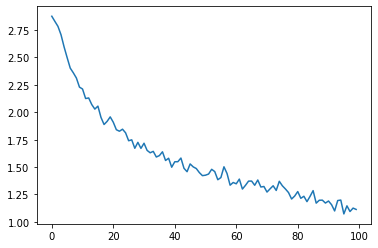

In [37]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_losses)

### Evaluation

Great, we have a trained model. Let's get a confusion matrix:

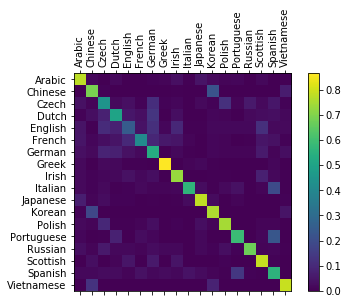

In [38]:
# Keep track of correct guesses in a confusion matrix
confusion = torch.zeros(n_categories, n_categories)
n_confusion = 10000

# Just return an output given a line
def evaluate(line_tensor):
    hidden = rnn.initHidden()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    return output

# Go through a bunch of examples and record which are correctly guessed
for i in range(n_confusion):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output = evaluate(line_tensor)
    guess, guess_i = categoryFromOutput(output)
    category_i = all_categories.index(category)
    confusion[category_i][guess_i] += 1

# Normalize by dividing every row by its sum
for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()

# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# sphinx_gallery_thumbnail_number = 2
plt.show()

Take a look at the most likely confusions and see if they make sense.

### Prediction on user input

Finally, try classifying novel inputs:

In [40]:
def predict(input_line, n_predictions=3):
    print('\n> %s' % input_line)
    with torch.no_grad():
        output = evaluate(lineToTensor(input_line))

        # Get top N categories
        topv, topi = output.topk(n_predictions, 1, True)
        predictions = []

        for i in range(n_predictions):
            value = topv[0][i].item()
            category_index = topi[0][i].item()
            print('(%.2f) %s' % (value, all_categories[category_index]))
            predictions.append([value, all_categories[category_index]])

predict('Dovesky')
predict('Jackson')
predict('Higanbana')
predict('pongkorn')


> Dovesky
(-0.72) Czech
(-0.97) Russian
(-2.28) English

> Jackson
(-0.32) Scottish
(-1.65) English
(-3.28) Russian

> Higanbana
(-0.34) Japanese
(-2.87) Spanish
(-2.89) Italian

> pongkorn
(-0.94) English
(-1.75) German
(-2.15) Dutch


### Exercises

Try the following:

1. Change the structure to be identical to Goodfellow's Figure 10.3 with tanh activation functions
   and see if you get different results.
   
2. Explore methods for batching patterns of different length prior to presentation to a RNN and
   implement them. See how much speedup you can get from the GPU with minibatch training.

3. Do a bit of research on similar problems such as named entity recognition, find a dataset,
   train a model, and report your results.

### The report

As always, your report is due next week. Please submit via Google Classroom.